# Predictors of arsenic content in goundwater
The State of Durango, in northern Mexico, is one of those affected with significant natural presence of arsenic in groundwater (for a national analysis, see [this previous post](https://danielmartinalarcon.github.io/2018-12-14-water-pollution-in-mexico/)).  One of the problems with studying arsenic is that it's expensive to measure it accurately.  But what if we could reliably predict the arsenic content of a water sample, based on other characteristics of the water that are easier to determine?

I used a dataset of water samples from Durango, for which the levels of several common ions had been quantified.  I trained several regression models on these data and found that potassium (K) is by far the factor that is most closely associated with arsenic presence in this dataset.  

## Data cleanup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
import category_encoders as ce
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression

pd.set_option('display.max_columns', None)  # Unlimited columns

In [2]:
df = pd.read_csv('water_samples.csv', index_col=0)

In [3]:
# Initial state of the dataframe
print(df.shape)
df.head()

(146, 22)


,Municipio,Localidad,Coordenadas,Unnamed: 3,Muestra,FECHA DE MUESTREO,pH,Conductividad (μs/cm),As (μg/L),Flúor (mg/L),Na+ (mg/L),K+ (mg/L),Fe+ (mg/L),Ca+ (mg/L),Mg+ (mg/L),NO3- (mg/L),Cl- (mg/L),CO3-2 (mg/L),HCO3- (mg/L),Alcalinidad total (mg CaCO3/L),SO4,Tipo de Agua
0,NaN,NaN,Longitud,Latitud,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Durango,El Nayar,-104.69545,23.96292,60.0,2017-08-08,8.140,337.0,61.5,3.15,40.9220,1.4075,0.007,15.0015,0.2675,3.25,4.140,0.0,97.0,97.0,70.615,BICARBONATADA SODICA
2,Durango,Sebastián Lerdo de Tejada,-104.64026,23.95718,61.0,2017-08-08,8.110,406.0,38.5,2.60,45.8850,0.6100,NaN,20.1530,0.0645,2.10,2.040,0.0,122.0,122.0,79.445,BICARBONATADA SODICA
3,Durango,Felipe Ángeles,-104.55661,23.93505,62.0,2017-08-08,8.375,384.1,26.5,1.40,38.5360,6.3665,NaN,21.8090,1.1890,1.35,2.325,0.0,140.0,140.0,53.730,BICARBONATADA SODICA
4,Durango,Villa Montemorelos,-104.48167,23.99177,63.0,2017-08-08,8.500,557.5,23.5,1.20,31.6805,6.7350,NaN,32.8330,6.5825,4.40,4.680,0.0,206.5,206.5,60.245,BICARBONATADA CALCICA Y/O MAGNESICA


In [4]:
# I rename all columns with simpler English names
df2 = df.rename(
    {'Municipio':'municipality',
     'Localidad':'town',
     'Coordenadas':'longitude',
     'Unnamed: 3':'latitude',
     'Muestra':'id',
     'FECHA DE MUESTREO ':'sampling_date',
     'pH':'pH',
     'Conductividad (μs/cm)':'conductivity',
     'As (μg/L)':'As',
     'Flúor (mg/L)':'F',
     'Na+ (mg/L)':'Na',
     'K+    (mg/L)':'K',
     'Fe+ (mg/L)':'Fe',
     'Ca+ (mg/L)':'Ca',
     'Mg+ (mg/L)':'Mg',
     'NO3- (mg/L)':'nitrate',
     'Cl- (mg/L)':'Cl',
     ' CO3-2 (mg/L)':'carbonate',
     'HCO3- (mg/L)':'bicarbonate',
     'Alcalinidad total                (mg CaCO3/L)':'total_alcalinity',
     'SO4':'sulfate',
     'Tipo de Agua':'water_type'}, axis='columns')

# The first row is garbage
df2 = df2.drop(index=0)

# The id column shouldn't have any predictive power
df2 = df2.drop(columns='id')

# The column for iron (Fe) is the only one with null values, and has 128/146. 
# Probably not worth fixing, so I'll drop it.
df2 = df2.drop(columns='Fe')

# I assume that the sampling date is not important.
df2 = df2.drop(columns='sampling_date')

# I'm only interested in variables that are likely to generalize to 
# other datasets. Though there may be some extra predictive power in the
# locations of these samples, that seems specific to this dataset.
# I will drop geographic variables.

df2 = df2.drop(columns=['longitude','latitude','municipality','town'])

# I'll also reorder the columns a bit
df2 = df2[['As', # Dependent variable first
 'pH',
 'conductivity',
 'F',
 'Na',
 'K',
 'Ca',
 'Mg',
 'nitrate',
 'Cl',
 'carbonate',
 'bicarbonate',
 'total_alcalinity',
 'sulfate',
 'water_type' # Categorical feature last
]]

In [7]:
# Brief look at the clean dataframe
print(df2.shape)
df2.head()

(145, 15)


,As,pH,conductivity,F,Na,K,Ca,Mg,nitrate,Cl,carbonate,bicarbonate,total_alcalinity,sulfate,water_type
1,61.5,8.140,337.0,3.15,40.9220,1.4075,15.0015,0.2675,3.25,4.140,0.0,97.0,97.0,70.615,BICARBONATADA SODICA
2,38.5,8.110,406.0,2.60,45.8850,0.6100,20.1530,0.0645,2.10,2.040,0.0,122.0,122.0,79.445,BICARBONATADA SODICA
3,26.5,8.375,384.1,1.40,38.5360,6.3665,21.8090,1.1890,1.35,2.325,0.0,140.0,140.0,53.730,BICARBONATADA SODICA
4,23.5,8.500,557.5,1.20,31.6805,6.7350,32.8330,6.5825,4.40,4.680,0.0,206.5,206.5,60.245,BICARBONATADA CALCICA Y/O MAGNESICA
5,97.5,8.330,326.1,5.95,45.6745,1.6525,8.5190,0.2100,0.52,5.390,0.0,83.0,83.0,59.880,BICARBONATADA SODICA


## Train/test sets


In [8]:
X = df2.drop(columns='As')
y = df2['As']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42)

# Verify all shapes
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((130, 14), (15, 14), (130,), (15,))

I'll store `X_test` and `y_test` for later, and carry out all further training and validation with the other datasets only.

## Data Exploration
Let's take a quick look at what Arsenic levels are present in our training data, and whether we need to worry much about outliers.

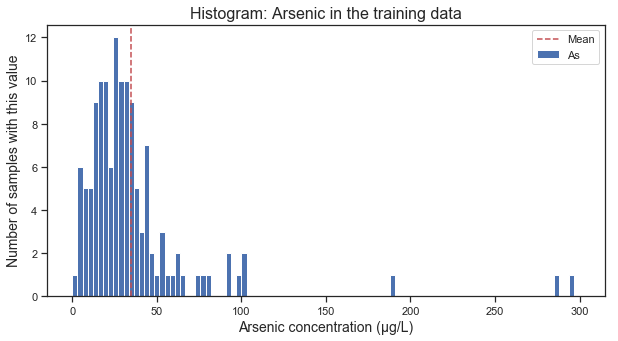

In [98]:
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(y_train, bins=np.linspace(0,300,100))
ax.set_xlabel('Arsenic concentration (µg/L)', fontsize=14)
ax.set_ylabel('Number of samples with this value', fontsize=14)
plt.axvline(x=35, color='r', linestyle='--', label='Mean');
plt.legend();
plt.title('Histogram: Arsenic in the training data', fontsize=16);

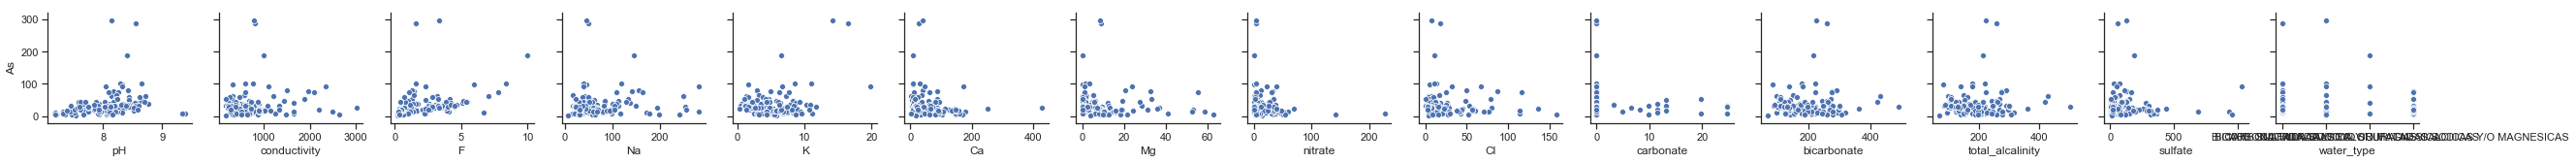

In [10]:
sns.set(style="ticks", color_codes=True)
x_vars = X_train.columns
sns.pairplot(data=df2, y_vars=['As'], x_vars=x_vars)
plt.show()

Looks like there's a few outliers in both X and y, so I'll use RobustScaler to scale all my data.  As an interesting side-note, it looks as if arsenic concentration has a log-normal distribution.

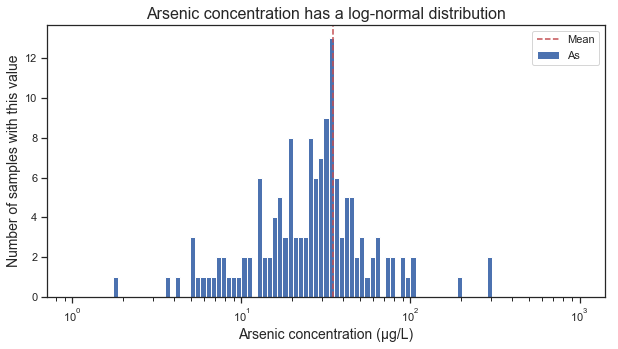

In [99]:
df3 = df2
df3['ln_As'] = np.log(df3['As'])

fig, ax = plt.subplots(figsize=(10,5))
ax.hist(df3['As'], bins=np.logspace(0,3,100))
ax.set_xlabel('Arsenic concentration (µg/L)', fontsize=14)
ax.set_ylabel('Number of samples with this value', fontsize=14)
ax.set_xscale('log')
plt.axvline(x=35, color='r', linestyle='--', label='Mean');
plt.legend();
plt.title('Arsenic concentration has a log-normal distribution', fontsize=16);

# Baseline Model

I'll start with the simplest possible model: assuming that all wells have an arsenic concentration equal to the mean of the training set.  This will provide a baseline score that I can use to judge more complex models.

In [11]:
# Because I want to keep track of the results from several models, 
# I'll create a dataframe to track them.
scorecard = pd.DataFrame(columns = ['Model', 'RMSE','R^2'])

In [12]:
# And the mean value is..
np.mean(y_train)

36.05243022607692

In [13]:
y_pred = [np.mean(y_train)] * len(y_train)
RMSE = np.sqrt(mean_squared_error(y_train, y_pred))
R2 = r2_score(y_train, y_pred)
scorecard = scorecard.append({'Model':'Mean Everywhere', 'RMSE':RMSE, 'R^2':R2},
                ignore_index=True)
scorecard

,Model,RMSE,R^2
0,Mean Everywhere,40.286292,0.0


# Linear Regression
Start simple.

In [14]:
# One-hot encode the one categorical variable 
# (also in test dataset, lest we forget)
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [15]:
# Create a pipeline to scale and regress
pipe = make_pipeline(
    RobustScaler(),  
    LinearRegression())

# Fit on the train set
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_train)

# Fit on the train set, with grid search cross-validation
gs = GridSearchCV(pipe, param_grid={}, cv=10, 
                  scoring='neg_mean_squared_error')

gs.fit(X_train, y_train);
validation_score = np.sqrt(-gs.best_score_)
print()
print('Mean RMSE in cross-validation: ', validation_score)
print()


Mean RMSE in cross-validation:  40.18115199336001



In [16]:
# Score results
y_pred = gs.predict(X_train)
R2 = r2_score(y_train, y_pred)
scorecard = scorecard.append({'Model':'Linear Regression', 'RMSE':validation_score, 'R^2':R2},
                ignore_index=True)
scorecard

,Model,RMSE,R^2
0,Mean Everywhere,40.286292,0.000000
1,Linear Regression,40.181152,0.413865


# Ridge Regression

In [ ]:
%%time

pipe = make_pipeline(
    RobustScaler(),  
    SelectKBest(f_regression), 
    Ridge())

# I'll find the optimal number of features, and also try out several
# values of alpha
param_grid = {
    'selectkbest__k': range(1, len(X_train.columns)), 
    'ridge__alpha': [0, 0.1, 1.0, 10., 100.]
}

# Fit on the train set, with grid search cross-validation
gs = GridSearchCV(pipe, param_grid=param_grid, cv=10, 
                  scoring='neg_mean_squared_error')

gs.fit(X_train, y_train)

In [18]:
validation_score = np.sqrt(-gs.best_score_)
print()
print('Mean RMSE in cross-validation: ', validation_score)


Mean RMSE in cross-validation:  35.26583153352785


In [19]:
# Which features were selected by SelectKBest?
selected_mask = gs.best_estimator_.named_steps['selectkbest'].get_support()
selected_names = X_train.columns[selected_mask]
unselected_names = X_train.columns[~selected_mask]
coefs = gs.best_estimator_.named_steps['ridge'].coef_

print('Best parameters from cross-validation:')
for key, value in gs.best_params_.items():
    print(f'{key}: {value}')
print()
    
print('Selected Features and regression coefficients:')
for name, coef in zip(selected_names, coefs):

    print(f'{name:5}{coef:.2f}')

print()
print('Features not selected:')
for name in unselected_names:
    print(f'> {name}')

Best parameters from cross-validation:
ridge__alpha: 10.0
selectkbest__k: 3

Selected Features and regression coefficients:
pH   11.62
F    14.26
K    20.44

Features not selected:
> conductivity
> Na
> Ca
> Mg
> nitrate
> Cl
> carbonate
> bicarbonate
> total_alcalinity
> sulfate
> water_type_BICARBONATADA CALCICA Y/O MAGNESICA
> water_type_BICARBONATADA SODICA
> water_type_CLORURADAS Y/O SULFATADAS SODICAS
> water_type_SULFATADA Y/O CLORURADAS CALCICAS Y/O MAGNESICAS


Looks like pH, F, and K are the most important features for predicting arsenic concentration.  There's some valuable insight right there.

In [20]:
# Score results
y_pred = gs.predict(X_train)
R2 = r2_score(y_train, y_pred)
scorecard = scorecard.append({'Model':'Ridge Regression', 'RMSE':validation_score, 'R^2':R2},
                ignore_index=True)
scorecard

,Model,RMSE,R^2
0,Mean Everywhere,40.286292,0.000000
1,Linear Regression,40.181152,0.413865
2,Ridge Regression,35.265832,0.325887


# Adding polynomial features

In [21]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
X_train_polynomial = poly.fit_transform(X_train)
print(X_train.shape, X_train_polynomial.shape)

(130, 17) (130, 171)


In [ ]:
%%time

pipe = make_pipeline(
    RobustScaler(),  
    SelectKBest(f_regression), 
    Ridge())

param_grid = {
    'selectkbest__k': range(1, 10), 
    'ridge__alpha': [0, 0.1, 1.0, 10.]
}

# Fit on the train set, with grid search cross-validation
gs = GridSearchCV(pipe, param_grid=param_grid, cv=10, 
                  scoring='neg_mean_squared_error')

gs.fit(X_train_polynomial, y_train)

In [23]:
validation_score = np.sqrt(-gs.best_score_)
print()
print('Mean RMSE in cross-validation: ', validation_score)


Mean RMSE in cross-validation:  34.83497412458334


In [24]:
# Which features were selected by SelectKBest?
all_names = np.array(poly.get_feature_names(X_train.columns))
selected_mask = gs.best_estimator_.named_steps['selectkbest'].get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]
coefs = gs.best_estimator_.named_steps['ridge'].coef_

print('Best parameters from cross-validation:')
for key, value in gs.best_params_.items():
    print(f'{key}: {value}')
print()
    
print('Selected Features and regression coefficients:')
for name, coef in zip(selected_names, coefs):
    print(f'{name:20}{coef:.2f}')

print()
print('Features not selected:')
for name in unselected_names:
    print(f'> {name}')

Best parameters from cross-validation:
ridge__alpha: 1.0
selectkbest__k: 7

Selected Features and regression coefficients:
K                   -44.68
pH K                16.85
conductivity F      8.36
F K                 4.10
K^2                 29.12
K bicarbonate       0.20
K total_alcalinity  -4.90

Features not selected:
> 1
> pH
> conductivity
> F
> Na
> Ca
> Mg
> nitrate
> Cl
> carbonate
> bicarbonate
> total_alcalinity
> sulfate
> water_type_BICARBONATADA CALCICA Y/O MAGNESICA
> water_type_BICARBONATADA SODICA
> water_type_CLORURADAS Y/O SULFATADAS SODICAS
> water_type_SULFATADA Y/O CLORURADAS CALCICAS Y/O MAGNESICAS
> pH^2
> pH conductivity
> pH F
> pH Na
> pH Ca
> pH Mg
> pH nitrate
> pH Cl
> pH carbonate
> pH bicarbonate
> pH total_alcalinity
> pH sulfate
> pH water_type_BICARBONATADA CALCICA Y/O MAGNESICA
> pH water_type_BICARBONATADA SODICA
> pH water_type_CLORURADAS Y/O SULFATADAS SODICAS
> pH water_type_SULFATADA Y/O CLORURADAS CALCICAS Y/O MAGNESICAS
> conductivity^2
> c

Well, look at that.  We already knew that K (potassium) was important, but now that I've tested polynomial features it seems like K is way more important than we thought.  It's the most significant feature on its own, it shows up as K^2, and the other features seem to matter only inasmuch as they interact with K (though there's also the interaction between F and conductivity).  

In [31]:
# Score results
y_pred = gs.predict(X_train_polynomial)
R2 = r2_score(y_train, y_pred)
scorecard = scorecard.append({'Model':'Ridge Regression, Polynomial Features', 'RMSE':validation_score, 'R^2':R2},
                ignore_index=True)
scorecard

,Model,RMSE,R^2
0,Mean Everywhere,40.286292,0.000000
1,Linear Regression,40.181152,0.413865
2,Ridge Regression,35.265832,0.325887
3,"Ridge Regression, Polynomial Features",34.834974,0.431645


# Testing on test data
Alright, it seems like Ridge Regression with Polynomial Features wins.  Let's see how well it performs on the test data.

In [47]:
# X_train and X_test have different columns, because the one-hot encoder
# encountered a different set of options to encode.  Thus, I have to add 
# the missing column before running the polynomial feature generator
X_train.columns

Index(['pH', 'conductivity', 'F', 'Na', 'K', 'Ca', 'Mg', 'nitrate', 'Cl',
       'carbonate', 'bicarbonate', 'total_alcalinity', 'sulfate',
       'water_type_BICARBONATADA CALCICA Y/O MAGNESICA',
       'water_type_BICARBONATADA SODICA',
       'water_type_CLORURADAS Y/O SULFATADAS SODICAS',
       'water_type_SULFATADA Y/O CLORURADAS CALCICAS Y/O MAGNESICAS'],
      dtype='object')

In [48]:
X_test.columns

Index(['pH', 'conductivity', 'F', 'Na', 'K', 'Ca', 'Mg', 'nitrate', 'Cl',
       'carbonate', 'bicarbonate', 'total_alcalinity', 'sulfate',
       'water_type_BICARBONATADA CALCICA Y/O MAGNESICA',
       'water_type_BICARBONATADA SODICA',
       'water_type_SULFATADA Y/O CLORURADAS CALCICAS Y/O MAGNESICAS'],
      dtype='object')

In [51]:
# This column will get selected out anyway, so it's ok.
# I just need it here so that PolynomialFeatures will generate the right
# column names
X_test['water_type_CLORURADAS Y/O SULFATADAS SODICAS']=0

Index(['pH', 'conductivity', 'F', 'Na', 'K', 'Ca', 'Mg', 'nitrate', 'Cl',
       'carbonate', 'bicarbonate', 'total_alcalinity', 'sulfate',
       'water_type_BICARBONATADA CALCICA Y/O MAGNESICA',
       'water_type_BICARBONATADA SODICA',
       'water_type_SULFATADA Y/O CLORURADAS CALCICAS Y/O MAGNESICAS',
       'water_type_CLORURADAS Y/O SULFATADAS SODICAS'],
      dtype='object')

In [54]:
# Confirmed, they both have the same shape
poly = PolynomialFeatures(degree=2)
X_test_polynomial = poly.fit_transform(X_test)
X_test_polynomial.shape, X_train_polynomial.shape

((15, 171), (130, 171))

In [100]:
# Same gs as used last time.
y_pred = gs.predict(X_test_polynomial)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2 = r2_score(y_test, y_pred)
print(f'RMSE: {RMSE}')
print(f'R^2: {R2}')

RMSE: 20.812209976076126
R^2: -0.48578768514621995


The RMSE is within the range of what we expect. R^2 is negative, but I guess that happens with very small datasets like this one (15 test samples).